In [181]:
import numpy as np
import matplotlib.pyplot as plt
import os.path

from rikabtools.plot_utils import cmaps

from tqdm import tqdm


# Experiment Parameters

In [182]:
# ##### CONFIG FILE #####

config = np.load(f"experiments/Water/config_{10}.npy", allow_pickle=True)[()]


# ##### PARAMETERS #####
E_0 = config["E_0"]
m_lepton = config["Lepton Mass"]
theta_max = config["theta_max"]
x_max = 1 - m_lepton / E_0

xbins = config["xbins"]
dx = 1.0/xbins
xs = np.linspace(0, 1, xbins)

m_Xs = np.array(config["m_X"])
m_Xs = m_Xs[m_Xs < E_0]

# Target Stuff
target_name = config["Target Name"]
target_A = config["Target A"]
target_X0 = 1/(15e-6) # g/cm2, https://pdg.lbl.gov/2015/AtomicNuclearProperties/MUB/muB_tungsten_W.pdf @ 1-2 TeV, b_tot inverse
target_density = config["Target Density"] #g/cm3

# Experiment Parameters
l_target = 10 # Target Length (m)
l_detector = 100 # Detector Length (m)
l_shield = 10 # Shield Length (m)


# Format is [weight, mass]
decay_name = "Dark X"
decay_name_string = "darkX"
decay_dictionary = {"electrons" : [1, 0.000511],
                    "muons" : [1, 0.105],
                    "taus" : [1, 1.776],
                    "neutrinos" : [0, 0],
                    "hadrons" : [1, 0.105], # Weight gets multiplied by Rpp
                    }



# Options
run_IWW = config["IWW"]
run_WW = config["WW"]
cross_section_directory = config["Cross Sections Directory"]

if run_IWW:
    cross_section_dict = np.load(f"{cross_section_directory}.npy", allow_pickle=True)[()]
if run_WW:
    cross_section_dict = np.load(f"{cross_section_directory}_WW.npy", allow_pickle=True)[()]

# Constants
m_mu = 0.105
m_e = 0.000511
m_tau = 1.776
m_p = 0.937
alpha_EM = 1.0/137

hbarc = .197 # GeV fm
hbarc_cm_invGeV2 = hbarc * 1e-13
N_A = 6e23 # Avagadros number (mol^-1)

cases = ["Scalar", "Pseudoscalar", "Vector", "Axial Vector"]
colors = ["red", "yellow", "green", "blue"]



# Save config file and new information
config["Target Length"] = l_target
config["Shield Length"] = l_shield
config["Detector Length"] = l_detector
experiment_name_string = f"experiment_{decay_name_string}_e{E_0}_t{l_target}_s{l_shield}_d{l_detector}"
config["Experiment Directory"] = f"experiments/{target_name}/{experiment_name_string}"

l_target = l_target * 100 # Target Length (cm)
l_detector = l_detector * 100 # Detector Length (cm)
l_shield = l_shield * 100 # Shield Length (cm)


os.makedirs(f"experiments/{target_name}/{experiment_name_string}", exist_ok=True)
np.save(f"experiments/{target_name}/{experiment_name_string}/config", config)


# Calculate Lifetimes

Independent of cross sections
Decay length for each particle to decay to SM leptons and hadrons

In [183]:
def scalar_decay_width(m_X, epsilon, m_l):

    prefactor = epsilon**2 * alpha_EM / 2
    kinematic_factor = m_X * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2)**3)
    return prefactor * kinematic_factor




def pseudoscalar_decay_width(m_X, epsilon, m_l):

    prefactor = epsilon**2 * alpha_EM / 2
    kinematic_factor = m_X * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2))
    return prefactor * kinematic_factor



def vector_decay_width(m_X, epsilon, m_l):

    prefactor = epsilon**2 * alpha_EM / 3
    kinematic_factor = m_X * (1 + 2*m_l**2 / m_X**2) * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2))
    return prefactor * kinematic_factor

def axial_vector_decay_width(m_X, epsilon, m_l):

    prefactor = epsilon**2 * alpha_EM / 3
    kinematic_factor = m_X * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2)**3)
    return prefactor * kinematic_factor


decay_widths = [scalar_decay_width, pseudoscalar_decay_width, vector_decay_width, axial_vector_decay_width]



# R-Ratio

Data for $\sigma(\mu\mu \to had)$ / $\sigma(\mu\mu \to ee)$ from PDG (link: )

In [184]:
# Helper function to read PDG Data files
def is_float(string):
    """ True if given string is float else False"""
    try:
        return float(string)
    except ValueError:
        return False

pdg_r = []
with open('rpp_cleaned.dat', 'r') as f:
    d = f.readlines()
    for i in d:
        k = i.rstrip().split(" ")
        if "*" not in k:
            row = []
            for x in k:
                if x != "" and is_float(x):
                    row.append(float(x))
            if len(row) > 6 and is_float(row[0]):
                pdg_r.append(np.array(row[:7])) 

pdg_r = np.array(pdg_r)
def Rpp(m_X_linspace):
    return np.interp(m_X_linspace, pdg_r[:,0], pdg_r[:,3])



# # Plot the R-Ratio
# plt.rcParams.update({'font.size': 20})
# fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

# m_X_linspace = np.linspace(0,100,2500)
# plt.plot(pdg_r[:,0], pdg_r[:,3], color = "black", lw = "3", label = "PDG Exact")
# plt.plot(m_X_linspace, Rpp(m_X_linspace), color = "red", lw = "3", label = "Interpolation")
# plt.xlabel("$m_X$ [GeV]")
# plt.ylabel("$R$-Ratio")
# plt.xscale("log")
# plt.yscale("log")
# plt.title("PDG 2022 R-Ratio")
# plt.legend(frameon = False)


# Decay Lengths

/tmp/ipykernel_13229/790472952.py:4: RuntimeWarning: invalid value encountered in sqrt
  kinematic_factor = m_X * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2)**3)
/tmp/ipykernel_13229/3889757537.py:13: RuntimeWarning: divide by zero encountered in true_divide
  return 1e-15 * hbarc * gamma / total_decay_width
/tmp/ipykernel_13229/790472952.py:13: RuntimeWarning: invalid value encountered in sqrt
  kinematic_factor = m_X * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2))
/tmp/ipykernel_13229/790472952.py:21: RuntimeWarning: invalid value encountered in sqrt
  kinematic_factor = m_X * (1 + 2*m_l**2 / m_X**2) * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2))
/tmp/ipykernel_13229/790472952.py:27: RuntimeWarning: invalid value encountered in sqrt
  kinematic_factor = m_X * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2)**3)


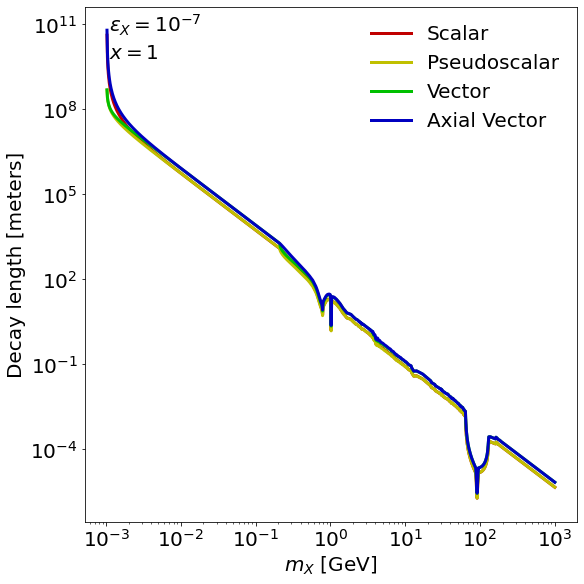

In [185]:



# Return the decay length of a particle with energy fraction x, mass m_X, coupling epsilon, in meters
def decay_length(decay_width, x, m_X, epsilon):

    gamma = (x * E_0) / m_X

    total_decay_width = 0
    for decay in decay_dictionary:
        weight, mass = decay_dictionary[decay]
        if decay == "hadrons":
            weight = Rpp(m_X) * weight
        total_decay_width += weight * decay_width(m_X, epsilon, mass)

    return 1e-15 * hbarc * gamma / total_decay_width



plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))


m_X_logspace = np.logspace(-3, 3, 1000)
eps_logspace = np.logspace(-10, -1, 1000)


# Plot for fun
for (c,case) in enumerate(cases):
    decay_lengths = decay_length(decay_widths[c], 1.0, m_X_logspace, 1e-7)
    plt.plot(m_X_logspace, decay_lengths, color = cmaps[colors[c]](0.75), lw = 3, label = case,)


plt.text(0.05, 1.00 - 0.05*1, r"$\epsilon_X = 10^{-7}$", fontsize = 20, transform = plt.gca().transAxes,)
plt.text(0.05, 1.00 - 0.05*2, r"$x = 1$", fontsize = 20, transform = plt.gca().transAxes,)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$m_X$ [GeV]")
# plt.title(f"{"Vector"} Case: " + r"$\mu+N \to \mu+N+A$")
plt.ylabel(r"Decay length [meters]")

plt.legend(frameon = False)
# labelLines(ax.get_lines(), zorder=2.5, fontsize = 14)



In [186]:
maximum_exponent = 250

# Function to interpolate (in log scale) the cross section between two pre-calculated mass points
def interpolate_cross_section(x, m_X, cross_sections):


    if x > x_max:
        return 0

    # logarithmic interpolation
    return (x > m_X / E_0) * dx * np.interp(m_X, m_Xs, np.nan_to_num([cross_sections[i][int(x * xbins)-1] for i in range(len(cross_sections))]))


# numpy-vectorized function to approximate log[exp(x)-1] when x is either very large or very small
def approximate_log_exp_minus_1(x, maximum_exponent, sign = 1):

    answer = np.nan_to_num(np.log(sign * (np.exp(x)-1)))

    # if x is large and positive
    large_positive_x_bools = (x > maximum_exponent) * (x > 0)
    answer = x*large_positive_x_bools + answer*(1-large_positive_x_bools)

    # if x is small, but positive
    small_positive_x_bools = (x < 1/maximum_exponent) * (x > 0)
    answer = np.nan_to_num(np.log(x)*small_positive_x_bools) + answer*(1-small_positive_x_bools)

    # if x is large and negative
    large_negative_x_bools = (-1*x > maximum_exponent) * (x < 0)
    answer = -np.exp(x)*large_negative_x_bools + answer*(1-large_negative_x_bools)

    # if x is small and negative
    small_negative_x_bools = (-1*x < 1/maximum_exponent) * (x < 0)
    answer = np.nan_to_num(np.log(-1 * x)*small_negative_x_bools) + answer*(1-small_negative_x_bools)

    return answer


# Calculate (the log of) dN/dx 
def log_normalized_dNdx(N_mu, x, m_X, epsilon, Gamma, cross_sections):
    
    if x > x_max:
        return -99999

    length = decay_length(Gamma, x, m_X, epsilon) * 100 # cm


    term1 = np.nan_to_num(np.log(target_density * length / target_A * hbarc_cm_invGeV2**2))
    term2 = np.nan_to_num(np.log(interpolate_cross_section(x, m_X, cross_sections)))
    

    term3 = np.nan_to_num(approximate_log_exp_minus_1(l_target / length, maximum_exponent, 1))
    term4 = np.nan_to_num(-1 * (l_target + l_shield) / length)


    term5 = np.nan_to_num(approximate_log_exp_minus_1(-1 * l_detector / length, maximum_exponent, -1))



    numerical_check_3 = (length > 0)

    numerical_check = numerical_check_3
    return (numerical_check * (term1 + term2 + term3 + term4 + term5) )


# Calculate the total number of events by integrating (the exponential of) log(dN/dX)
def compute_events(N_mu, m_X, epsilon, width, case):

    events = np.zeros_like(m_X)
    for (i, x) in tqdm(enumerate(xs)):


        length = decay_length(width, x, m_X, epsilon) * 100 # cm
        experiment_lengthscale = l_detector + l_shield + l_target

        # Check to make sure that the decay length is both positive and not too big
        numerical_check_3 = (length > 0) #* (length < maximum_exponent * experiment_lengthscale)

        numerical_check = numerical_check_3
        dNdX = log_normalized_dNdx(N_mu, x, m_X, epsilon, width, cross_section_dict[case])
        events += numerical_check * np.exp(( np.nan_to_num(dNdX)))
    return N_A * N_mu * events 

(0.001, 10)

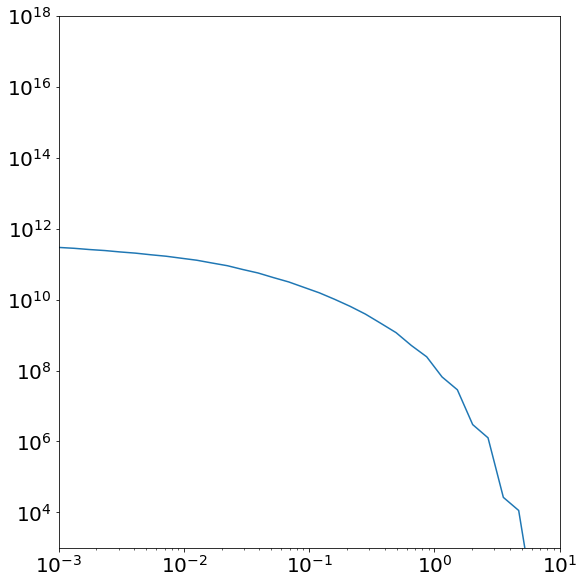

In [187]:
# numerical check (delete this cell later)

temp = np.logspace(-3, 3, 50)

temp2 = interpolate_cross_section(0.0, temp, cross_section_dict["Vector"])
for x in xs[1:]:
    temp2 = temp2 + interpolate_cross_section(x, temp, cross_section_dict["Vector"])

geV2_to_mb = 0.389
mb_to_fb = 1e12


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

plt.plot(temp, temp2 * geV2_to_mb * mb_to_fb)
plt.xscale("log")
plt.yscale("log")

plt.ylim([1e3, 1e18])
plt.xlim([1e-3, E_0])

In [188]:
N_mu = 1e20
m_X_logspace = np.logspace(-2, 1.2, 250)
epsilon_logspace = np.logspace(-10, -2, 250)

m_X_linspace = np.linspace(-2, 1.2, 250)
epsilon_linspace = np.linspace(-10, -2, 250)

M, E = np.meshgrid(m_X_logspace, epsilon_logspace)
Mlin, Elin = np.meshgrid(m_X_linspace, epsilon_linspace)

if not os.path.isfile(f"experiments/{target_name}/{experiment_name_string}/event_counts.npy"):

    # Calculate everything
    scalar_events = E**2 * compute_events(N_mu, M, E, scalar_decay_width, cases[0])
    psuedoscalar_events = E**2 * compute_events(N_mu, M, E, pseudoscalar_decay_width, cases[1])
    vector_events = E**2 * compute_events(N_mu, M, E, vector_decay_width, cases[2])
    axial_vector_events = E**2 * compute_events(N_mu, M, E, axial_vector_decay_width, cases[3])


    events_dict = {
        "Scalar" : scalar_events,
        "Pseudoscalar" : psuedoscalar_events,
        "Vector" : vector_events,
        "Axial Vector" : axial_vector_events,
    }


    np.save(f"experiments/{target_name}/{experiment_name_string}/event_counts.npy", events_dict)


0it [00:00, ?it/s]/tmp/ipykernel_13229/790472952.py:4: RuntimeWarning: invalid value encountered in sqrt
  kinematic_factor = m_X * np.nan_to_num( np.sqrt(1 - 4 * m_l**2 / m_X**2)**3)
/tmp/ipykernel_13229/2204583156.py:47: RuntimeWarning: divide by zero encountered in log
  term1 = np.nan_to_num(np.log(target_density * length / target_A * hbarc_cm_invGeV2**2))
/tmp/ipykernel_13229/2204583156.py:48: RuntimeWarning: divide by zero encountered in log
  term2 = np.nan_to_num(np.log(interpolate_cross_section(x, m_X, cross_sections)))
/tmp/ipykernel_13229/2204583156.py:51: RuntimeWarning: divide by zero encountered in true_divide
  term3 = np.nan_to_num(approximate_log_exp_minus_1(l_target / length, maximum_exponent, 1))
/tmp/ipykernel_13229/2204583156.py:25: RuntimeWarning: invalid value encountered in multiply
  answer = np.nan_to_num(np.log(x)*small_positive_x_bools) + answer*(1-small_positive_x_bools)
/tmp/ipykernel_13229/2204583156.py:29: RuntimeWarning: invalid value encountered in mul

experiments/Water/experiment_darkX_e10_t10_s5_d100
experiments/Water/experiment_darkX_e10_t10_s10_d100
experiments/Water/experiment_darkX_e10_t10_s20_d100


/tmp/ipykernel_13229/3858452302.py:15: RuntimeWarning: divide by zero encountered in log10
  white_events = np.log10(evs[case])
/tmp/ipykernel_13229/3858452302.py:19: RuntimeWarning: divide by zero encountered in log10
  contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
/tmp/ipykernel_13229/3858452302.py:19: UserWarning: The following kwargs were not used by contour: 'lw', 'label', 'inline'
  contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


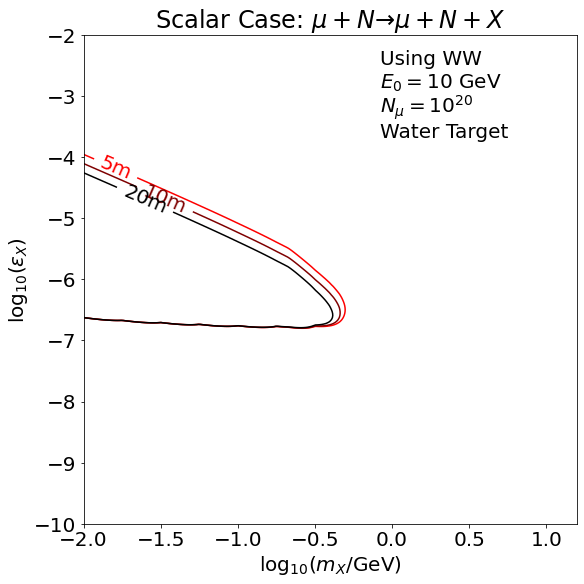

/tmp/ipykernel_13229/3858452302.py:15: RuntimeWarning: divide by zero encountered in log10
  white_events = np.log10(evs[case])
/tmp/ipykernel_13229/3858452302.py:19: RuntimeWarning: divide by zero encountered in log10
  contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
/tmp/ipykernel_13229/3858452302.py:19: UserWarning: The following kwargs were not used by contour: 'lw', 'label', 'inline'
  contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


experiments/Water/experiment_darkX_e10_t10_s5_d100
experiments/Water/experiment_darkX_e10_t10_s10_d100
experiments/Water/experiment_darkX_e10_t10_s20_d100


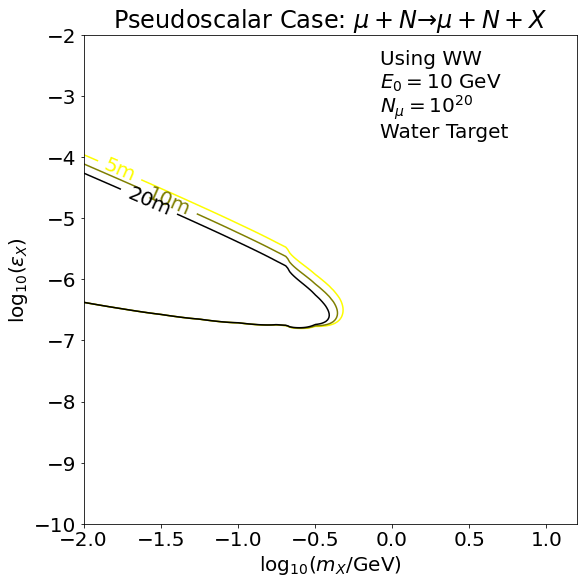

/tmp/ipykernel_13229/3858452302.py:15: RuntimeWarning: divide by zero encountered in log10
  white_events = np.log10(evs[case])
/tmp/ipykernel_13229/3858452302.py:19: RuntimeWarning: divide by zero encountered in log10
  contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
/tmp/ipykernel_13229/3858452302.py:19: UserWarning: The following kwargs were not used by contour: 'lw', 'label', 'inline'
  contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


experiments/Water/experiment_darkX_e10_t10_s5_d100
experiments/Water/experiment_darkX_e10_t10_s10_d100
experiments/Water/experiment_darkX_e10_t10_s20_d100


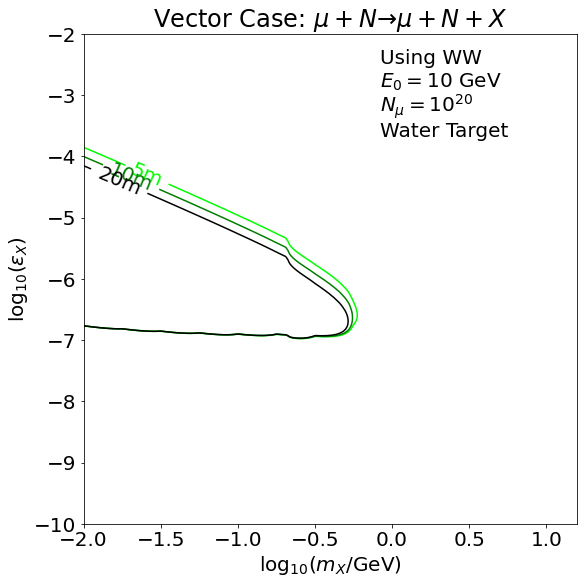

/tmp/ipykernel_13229/3858452302.py:15: RuntimeWarning: divide by zero encountered in log10
  white_events = np.log10(evs[case])
/tmp/ipykernel_13229/3858452302.py:19: RuntimeWarning: divide by zero encountered in log10
  contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
/tmp/ipykernel_13229/3858452302.py:19: UserWarning: The following kwargs were not used by contour: 'lw', 'label', 'inline'
  contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


experiments/Water/experiment_darkX_e10_t10_s5_d100
experiments/Water/experiment_darkX_e10_t10_s10_d100
experiments/Water/experiment_darkX_e10_t10_s20_d100


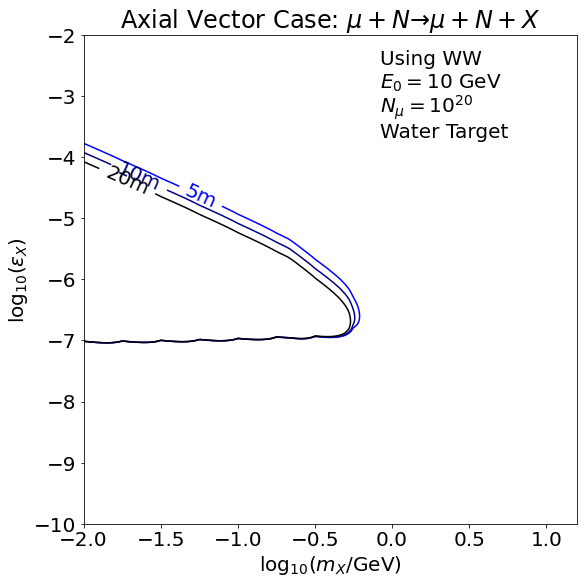

In [198]:
colormaps = ["Reds", "YlOrBr", "Greens", "Blues"]

# function to load the event counts dictionary from the default directory
def load_events_dict(target, decay, energy, l_target_, l_shield_, l_detector_):

    experiment_name_string_ = f"experiments/{target}/experiment_{decay}_e{energy}_t{l_target_}_s{l_shield_}_d{l_detector_}"
    print(experiment_name_string_)
    return np.load(f"{experiment_name_string_}/event_counts.npy", allow_pickle=True)[()]


# Function to plot a single contour
def plot_contour(case, c, evs, weight = np.log(5), color = "", color_weight = 1, label = ""):


    white_events = np.log10(evs[case])
    white_events[white_events  < 0 ] = np.NaN
    if color == "":
        color = cmaps[colors[c]](0.99 * color_weight)
    contours = plt.contour(Mlin,Elin, np.log10(evs[case]), levels = [weight,], lw = 3, colors = [color,], label = "5 Events", inline = "True")#, levels = [5], colors = [colors[i]])
    if label == "":
        plt.clabel(contours, inline=True, levels=[weight,])
    else:
        plt.clabel(contours, inline=True, levels=[weight,], fmt = {contours.levels[0] : label})





for (c, case) in enumerate(cases):
    if c < 4:

        plt.rcParams.update({'font.size': 20})
        fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))


        # two experiments
        exp1 = load_events_dict("Water", "darkX", 10, 10, 5, 100)
        exp2 = load_events_dict("Water", "darkX", 10, 10, 10, 100)
        exp3 = load_events_dict("Water", "darkX", 10, 10, 20, 100)

        plot_contour(case, c, exp1, label= "5m")
        plot_contour(case, c, exp2, color_weight= 0.5, label= "10m")
        plot_contour(case, c, exp3, color_weight= 0.0, label= "20m")



        plt.xlabel("log$_{10}(m_X/$GeV)")
        plt.ylabel("log$_{10}(\epsilon_X)$")
        plt.title(f"{case} Case: " + r"$\mu+N \to \mu+N+X$")

        if not run_WW:
            plt.text(0.6, 0.99 - 0.05*1, r"Using IWW", fontsize = 20, transform = plt.gca().transAxes)
        else:
            plt.text(0.6, 0.99 - 0.05*1, r"Using WW", fontsize = 20, transform = plt.gca().transAxes)
        plt.text(0.6, 0.99 - 0.05*2, r"$E_0 = %d$ GeV" % E_0, fontsize = 20, transform = plt.gca().transAxes)
        plt.text(0.6, 0.99 - 0.05*3, r"$N_\mu = 10^{20}$", fontsize = 20, transform = plt.gca().transAxes)
        plt.text(0.6, 0.99 - 0.05*4, f"{target_name} Target", fontsize = 20, transform = plt.gca().transAxes)
        plt.legend(frameon = False, loc = "upper left")

        # plt.savefig(f"tex/Figures/exclusions_{case}_{E_0}.pdf", transparent = False)
        plt.savefig(f"{config['Experiment Directory']}/exclusions_{case}.pdf", transparent = False)
        plt.show()

# plt.xscale("log")
# plt.yscale("log")
